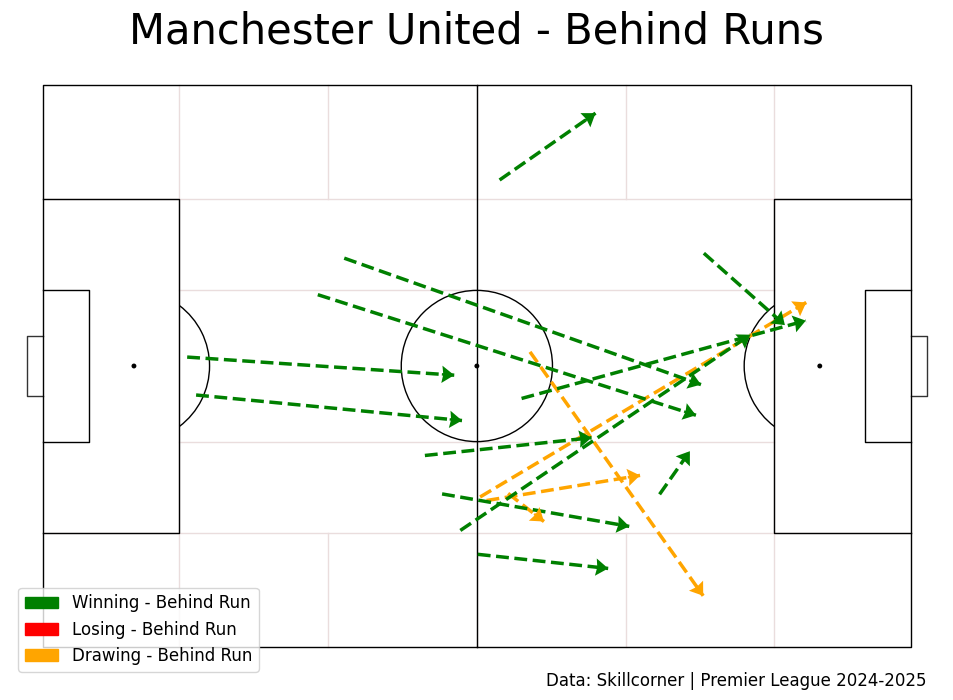

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.patches as mpatches

# Load CSV
df = pd.read_csv("/Users/marclambertes/Downloads/Wyscout/2007863_off_ball_runs.csv")

# Filter for overlap runs for Slavia Prague
team_to_analyze = "Manchester U"
df_runs = df[(df["event_type"] == "off_ball_run") & 
             (df["team_shortname"] == team_to_analyze) & 
             (df["event_subtype"] == "behind")]

# Set up the pitch
pitch = Pitch(positional=True, pitch_type='skillcorner', pitch_color='white', line_color='black',
              linewidth=1, half=False, goal_type='box', goal_alpha=0.8, 
              pitch_length=105, pitch_width=68)

# Create figure
fig, ax = pitch.draw(figsize=(10, 7))

### 🔹 Plot Off-Ball Runs (Dashed lines + arrowheads)
legend_patches = []  # Store legend items

for _, row in df_runs.iterrows():
    if 'game_state' in df_runs.columns:
        if row['game_state'] == "winning":
            color = 'green'
        elif row['game_state'] == "losing":
            color = 'red'
        elif row['game_state'] == "drawing":
            color = 'orange'
        else:
            color = 'gray'
    else:
        color = 'gray'
    
    # Draw dashed line
    pitch.lines(row["x_start"], row["y_start"], row["x_end"], row["y_end"], 
                linestyle="--", linewidth=2.5, color=color, ax=ax, zorder=2)
    
    # Draw arrowhead
    arrow_length = 1.5
    dx = row["x_end"] - row["x_start"]
    dy = row["y_end"] - row["y_start"]
    distance = np.hypot(dx, dy)
    
    if distance > 0:
        pitch.arrows(row["x_end"] - (arrow_length * dx / distance),
                     row["y_end"] - (arrow_length * dy / distance),
                     row["x_end"], row["y_end"], 
                     width=2.5, headwidth=7, headlength=5, color=color, ax=ax, zorder=3)

# Add legend
legend_patches.append(mpatches.Patch(color='green', label='Winning - Behind Run'))
legend_patches.append(mpatches.Patch(color='red', label='Losing - Behind Run'))
legend_patches.append(mpatches.Patch(color='orange', label='Drawing - Behind Run'))

plt.title(f"Manchester United - Behind Runs", fontsize=30)
ax.legend(handles=legend_patches, loc='lower left', fontsize=12)
plt.figtext(0.95, 0.02, 'Data: Skillcorner | Premier League 2024-2025', ha='right', va='center', fontsize=12, color='black')

# Save the plot
plt.savefig("slavia_prague_overlap_runs.png", dpi=300, bbox_inches='tight')
plt.show()

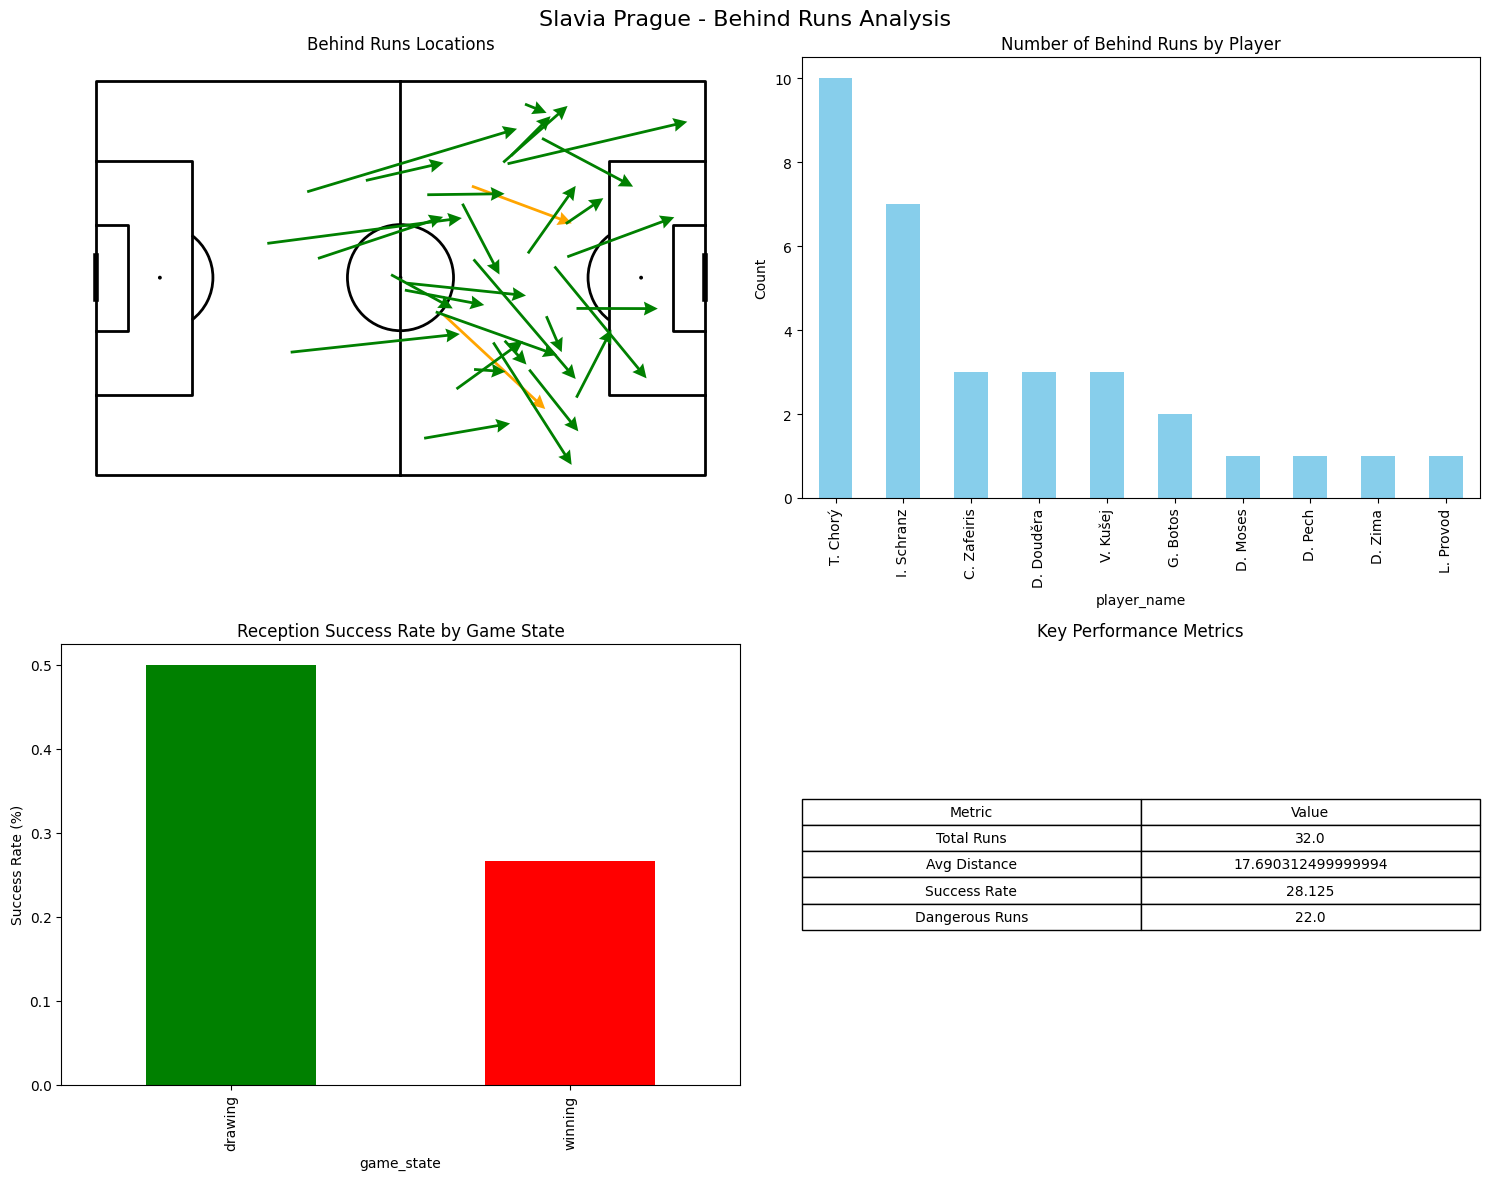


=== Overall Metrics ===
Total behind runs: 32
Success rate: 28.1%
Average distance: 17.7 meters
Dangerous runs: 22

=== Player Metrics ===
             total_runs  successful_receptions  avg_distance  dangerous_runs  \
player_name                                                                    
T. Chorý             10                      2     17.603000               7   
I. Schranz            7                      2     13.722857               3   
C. Zafeiris           3                      2     22.393333               2   
D. Douděra            3                      0     22.240000               3   
V. Kušej              3                      0     16.450000               3   
G. Botos              2                      1     13.985000               1   
D. Moses              1                      1     24.590000               1   
D. Pech               1                      1     34.030000               1   
D. Zima               1                      0      9.260000

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import matplotlib.patches as mpatches

# Load and filter data
df = pd.read_csv("/Users/marclambertes/Downloads/Wyscout/2007796_off_ball_runs.csv")
team = "Slavia Prague"
df_runs = df[(df["event_type"] == "off_ball_run") & 
             (df["team_shortname"] == team) & 
             (df["event_subtype"] == "behind")]

# 1. Basic Metrics Calculation
total_behind_runs = len(df_runs)
successful_receptions = df_runs["received"].sum()
success_rate = (successful_receptions / total_behind_runs * 100) if total_behind_runs > 0 else 0
avg_distance = df_runs["distance_covered"].mean()
dangerous_runs = df_runs["dangerous"].sum()

# 2. Player-specific Metrics
player_metrics = df_runs.groupby("player_name").agg({
    "event_id": "count",
    "received": "sum",
    "distance_covered": "mean",
    "dangerous": "sum",
    "speed_avg": "mean"
}).rename(columns={
    "event_id": "total_runs",
    "received": "successful_receptions",
    "distance_covered": "avg_distance",
    "dangerous": "dangerous_runs"
})

player_metrics["success_rate"] = (player_metrics["successful_receptions"] / 
                                 player_metrics["total_runs"] * 100)

# 3. Game State Analysis
game_state_metrics = df_runs.groupby("game_state").agg({
    "event_id": "count",
    "received": "mean",
    "dangerous": "mean"
}).rename(columns={
    "event_id": "count",
    "received": "reception_rate",
    "dangerous": "dangerous_rate"
})

# 4. Create Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Slavia Prague - Behind Runs Analysis", fontsize=16)

# 4.1 Pitch Visualization
pitch = Pitch(pitch_type='skillcorner', pitch_color='white', line_color='black',
              pitch_length=105, pitch_width=68)  # Added pitch dimensions
pitch.draw(ax=axes[0,0])
for _, row in df_runs.iterrows():
    color = {'winning':'green', 'losing':'red', 'drawing':'orange'}.get(row['game_state'], 'gray')
    pitch.arrows(row["x_start"], row["y_start"], row["x_end"], row["y_end"], 
                ax=axes[0,0], color=color, width=2, headwidth=5, headlength=5)
axes[0,0].set_title("Behind Runs Locations")

# 4.2 Player Performance
player_metrics.sort_values("total_runs", ascending=False)["total_runs"].plot(
    kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title("Number of Behind Runs by Player")
axes[0,1].set_ylabel("Count")

# 4.3 Success Rate by Game State
game_state_metrics["reception_rate"].plot(
    kind='bar', ax=axes[1,0], color=['green', 'red', 'orange'])
axes[1,0].set_title("Reception Success Rate by Game State")
axes[1,0].set_ylabel("Success Rate (%)")

# 4.4 Run Characteristics
run_stats = pd.DataFrame({
    "Metric": ["Total Runs", "Avg Distance", "Success Rate", "Dangerous Runs"],
    "Value": [total_behind_runs, avg_distance, success_rate, dangerous_runs]
})
axes[1,1].axis('off')
table = axes[1,1].table(cellText=run_stats.values,
                       colLabels=run_stats.columns,
                       loc='center',
                       cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
axes[1,1].set_title("Key Performance Metrics")

plt.tight_layout()
plt.savefig("slavia_prague_behind_runs_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Print metrics
print("\n=== Overall Metrics ===")
print(f"Total behind runs: {total_behind_runs}")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average distance: {avg_distance:.1f} meters")
print(f"Dangerous runs: {dangerous_runs}")

print("\n=== Player Metrics ===")
print(player_metrics.sort_values("total_runs", ascending=False))

print("\n=== Game State Metrics ===")
print(game_state_metrics)